In [96]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from collections import defaultdict
from qiskit import QuantumCircuit, Aer, execute

Given a Graph representing a 2-body interaction spin-glass, implement the QAOA circuit

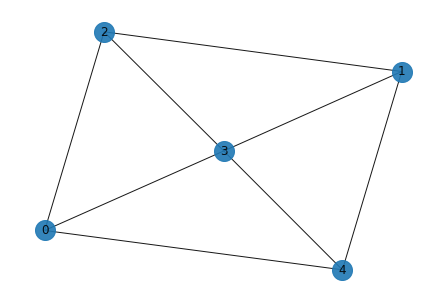

In [41]:
G = nx.Graph()
G.add_nodes_from([0,1,2,3,4])
G.add_edges_from([(1,2),(2,3),(3,4),(4,0),(0,3),(0,2),(1,3),(1,4)])
nx.draw(G,with_labels=True,alpha=0.9,node_size=400)

The interaction Hamiltonian is read from the edges, which means we can define the phase-separation unitary from the graph itself. For each edge (i,j) we need to implement the CNOT Rz CNOT acocunting for exp(-i/2 gamma sigma_z^i sigma_z^j) between i and j.

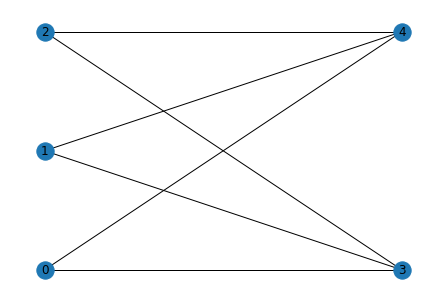

In [49]:
G = nx.Graph()
G.add_edges_from([[0,3],[0,4],[1,3],[1,4],[2,3],[2,4]])
nx.draw(G, with_labels=True, pos=nx.bipartite_layout(G, [0,1,2]))

In [21]:
def add_ising_term(circ,gamma,edge):
    i,j = edge
    circ.cx(i,j)
    circ.rz(gamma,j)
    circ.cx(i,j)
    pass

In [4]:
def add_quench_term(circ,theta,qubit):
    circ.rx(theta,qubit)
    pass

In [5]:
def get_phase_separation_step(G,gamma):
    n_qubits = len(G.nodes)
    phase_unitary = QuantumCircuit(n_qubits,n_qubits)
    ordered_edges = list(G.edges)
    ordered_edges.sort()
    for edge in ordered_edges:
        add_ising_term(phase_unitary,gamma,edge)
    return phase_unitary

In [14]:
def get_driver_step(G,theta):
    n_qubits = len(G.nodes)
    driver_unitary = QuantumCircuit(n_qubits,n_qubits)
    for qubit in range(n_qubits):
        add_quench_term(driver_unitary,theta,qubit)
    return driver_unitary
        

In [7]:
def get_QAOA_step(G,gamma,theta):
    phase_unitary = get_phase_separation_step(G,gamma)
    driver_unitary = get_driver_step(G,theta)
    return phase_unitary.compose(driver_unitary)
    

In [8]:
def get_initial_state(G):
    n_qubits = len(G.nodes)
    initial_state = QuantumCircuit(n_qubits,n_qubits)
    for qubit in range(n_qubits):
        initial_state.h(qubit)
    return initial_state

In [9]:
def invert_counts(counts):
    return {k[::-1]:v for k, v in counts.items()}

In [44]:
qc = QuantumCircuit(len(G.nodes),len(G.nodes))
qc = qc.compose(get_initial_state(G))
qc = qc.compose(get_QAOA_step(G,2,2))
qc.barrier(range(len(G.nodes)))
qc.measure(range(len(G.nodes)),range(len(G.nodes)))

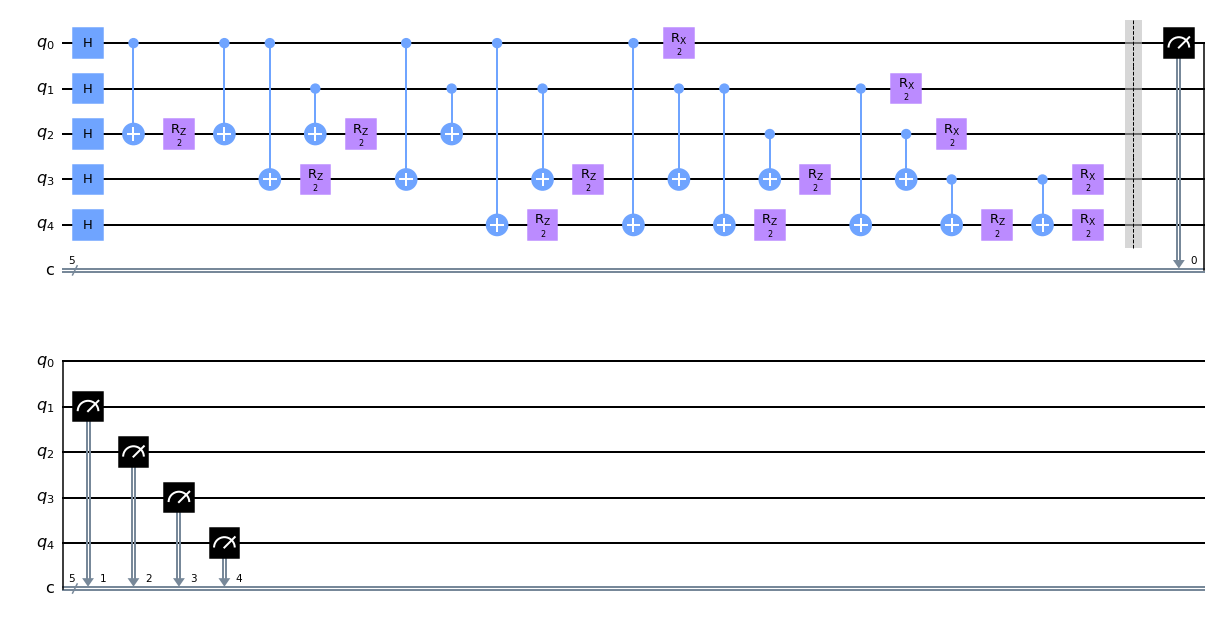

In [45]:
qc.draw('mpl')

In [39]:
backend  = Aer.get_backend('qasm_simulator')
job = execute(qc,backend)
result = job.result()
print(invert_counts(result.get_counts()))

{'01110': 2, '01010': 1, '10001': 1, '10011': 4, '01100': 4, '11001': 1, '10101': 3, '00001': 50, '00111': 5, '01111': 98, '01000': 97, '00101': 2, '10111': 82, '00110': 4, '10100': 4, '11000': 4, '00100': 100, '11011': 88, '00010': 47, '00011': 74, '11101': 60, '10000': 87, '11100': 76, '00000': 32, '01001': 3, '11111': 27, '11110': 63, '01011': 5}


In [51]:
def objective(state,G):
    vev = 0
    for edge in G.edges:
        if state[edge[0]] != state[edge[1]]:
            vev+=1
    return -vev

In [75]:
objective('00011',G)

-6

In [71]:
def sample_vev(result,G):
    counts = invert_counts(result.get_counts())
    acc = 0
    for state in counts.keys():
        acc+= objective(state,G)*counts[state]
    counts.values()
    total_counts = 0
    for count in counts.values():
        total_counts += count
    return acc/total_counts

In [72]:
sample_vev(result,G)

-2.7529296875

In order to use the clasical optimizers of scipy.optimize, we need f(theta,gamma) to optimze

In [86]:
def QAOA_circ(G,p,params):
    qc = QuantumCircuit(len(G.nodes),len(G.nodes))
    qc = qc.compose(get_initial_state(G))
    gamma = params[:p]
    theta = params[p:]
    for param in zip(gamma,theta):
        qc = qc.compose(get_QAOA_step(G,*param))   
    qc.barrier(range(len(G.nodes)))
    qc.measure(range(len(G.nodes)),range(len(G.nodes)))
    return qc

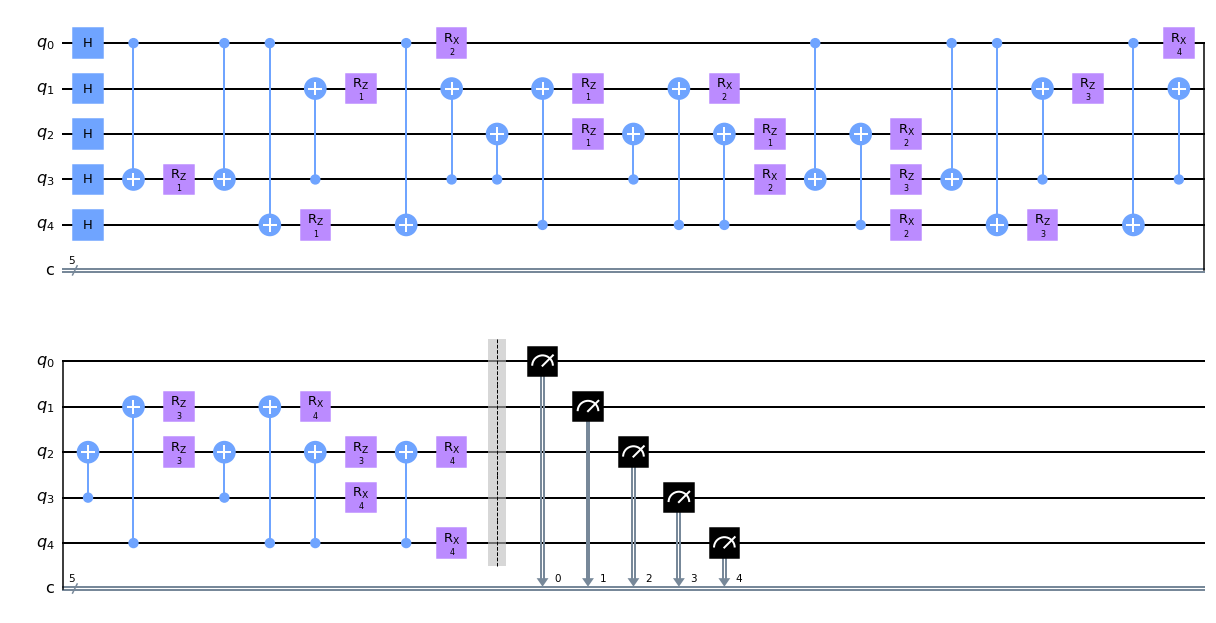

In [78]:
params = [(1,2),(3,4)]
qc = QAOA_circ(G,params)
qc.draw('mpl')

In [89]:
def circuit_objective(G,p,params):
    backend  = Aer.get_backend('qasm_simulator')
    qc = QAOA_circ(G,p,params)
    job = execute(qc,backend)
    result = job.result()
    return sample_vev(result,G)

In [94]:
def black_box_objective(G,p):
    backend  = Aer.get_backend('qasm_simulator')
    def f(params):
        qc = QAOA_circ(G,p,params)
        job = execute(qc,backend)
        result = job.result()
        return sample_vev(result,G)
    return f

In [95]:
params = [1,2,3,4]
black_box_objective(G,2)(params)

-3.15234375

In [101]:
p = 5
x0=[1,1,1,1,1,1,1,1,1,1]
minimize_result = minimize(black_box_objective(G,p),x0,method='COBYLA',options={'maxiter':2000,'disp':True})

In [102]:
minimize_result

     fun: -5.546875
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 132
  status: 1
 success: True
       x: array([1.74793848, 0.87051575, 1.13317195, 0.96751839, 0.89249791,
       1.28355043, 0.94909424, 0.95662145, 0.92730899, 1.20921203])

In [105]:
sol_params = minimize_result['x']
qc = QAOA_circ(G,p,sol_params)
backend  = Aer.get_backend('qasm_simulator')
job = execute(qc,backend)
result = job.result()
corrected_counts = invert_counts(result.get_counts())

In [106]:
corrected_counts

{'11011': 1,
 '00000': 1,
 '11010': 1,
 '01110': 1,
 '11001': 2,
 '11110': 18,
 '01100': 9,
 '00010': 10,
 '00110': 3,
 '10100': 7,
 '11100': 432,
 '00100': 1,
 '11000': 15,
 '01011': 14,
 '00011': 447,
 '11101': 13,
 '10011': 12,
 '00001': 15,
 '01111': 1,
 '00111': 16,
 '01001': 1,
 '11111': 2,
 '10001': 1,
 '10111': 1}

<BarContainer object of 5 artists>

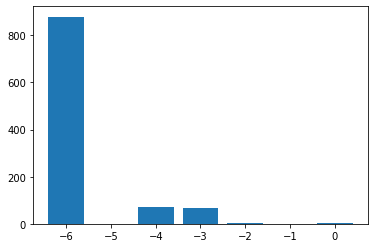

In [110]:
energies = defaultdict(int)
for k, v in corrected_counts.items():
    energies[objective(k,G)] += v
x,y = zip(*energies.items())
plt.bar(x,y)

Let's see an All-to-All connected system

In [114]:
def generate_all_to_all(n):
    edges = []
    for i in range(n):
        for j in range(n):
            if j>i:
                edges.append((i,j))
    return edges

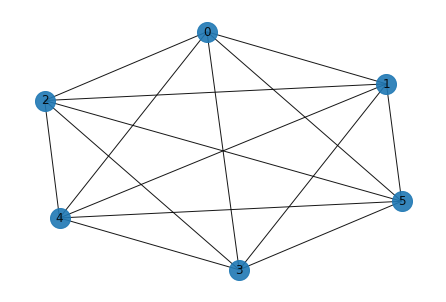

In [131]:
n = 6
G = nx.Graph()
G.add_nodes_from(range(n))
G.add_edges_from(generate_all_to_all(n))
nx.draw(G,with_labels=True,alpha=0.9,node_size=400)

In [132]:
p = 5
x0=[1,1,1,1,1,1,1,1,1,1]
minimize_result = minimize(black_box_objective(G,p),x0,method='COBYLA',options={'maxiter':3000,'disp':True})
minimize_result

     fun: -8.4345703125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 111
  status: 1
 success: True
       x: array([1.03221902, 1.05793419, 0.94744161, 1.1035848 , 0.8231281 ,
       1.01178838, 1.00432885, 0.93355476, 2.05140171, 0.97294673])

<BarContainer object of 4 artists>

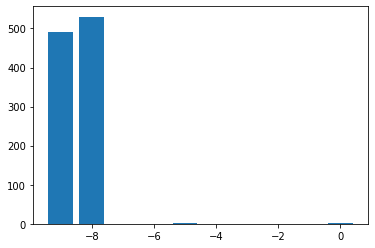

In [133]:
sol_params = minimize_result['x']
qc = QAOA_circ(G,p,sol_params)
backend  = Aer.get_backend('qasm_simulator')
job = execute(qc,backend)
result = job.result()
corrected_counts = invert_counts(result.get_counts())
energies = defaultdict(int)
for k, v in corrected_counts.items():
    energies[objective(k,G)] += v
x,y = zip(*energies.items())
plt.bar(x,y)

In [126]:
def generate_basis(n):
    def standardize_state(state,length):
        off_length = length - len(state)
        if off_length > 0 :
            standard_state = [0 for i in range(off_length)] + state
            return standard_state
        else:
            return state
    
    basis = []
    for element in range(2**n):
        basis.append([int(x) for x in list(bin(element)[2:])])
    generated_basis = [standardize_state(state,len(basis[-1])) for state in basis]
    return generated_basis

brute force solution

In [138]:
sol = np.array([objective(state,G) for state in generate_basis(n)])

In [140]:
i = 0
while sol[i]!=sol.min():
    i+=1

In [141]:
i

7

In [142]:
generate_basis(n)[7]

[0, 0, 0, 1, 1, 1]